In [43]:
###############################
##### inference with out of box model
###############################
import requests
from PIL import Image

from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel

# load a fine-tuned image captioning model and corresponding tokenizer and image processor
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# let's perform inference on an image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_path = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/val/01_4A799364-FADA-4722-BC9C-59D4C913B168.jpeg'

image = Image.open(image_path)
pixel_values = image_processor(image, return_tensors="pt").pixel_values

# autoregressively generate caption (uses greedy decoding by default)
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a large building with a lot of trucks parked in it 


In [42]:
from transformers import ViTImageProcessor, BertTokenizer, VisionEncoderDecoderModel

image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k", "google-bert/bert-base-uncased"
)
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id


/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertLMHeadModel were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossatten

In [65]:
#################################
###Initialize Dataset 
#################################

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import VisionTextDualEncoderModel, VisionTextDualEncoderProcessor, AdamW, DataCollatorWithPadding
from torch.optim import Adam
from torch.nn import functional as F
import torch
import random

# Mapping from class ID to class name
class_names = {
    0: 'DUMPSTER', 1: 'VEHICLE', 2: 'SKID_STEER', 3: 'EXCAVATOR', 4: 'VAN',
    5: 'LUMBER_BUNDLE', 6: 'CONE', 7: 'TRUCK', 8: 'GARBAGE_CONTAINER',
    9: 'LADDER', 10: 'POWER_GENERATOR', 11: 'TELESCOPIC_HANDLER',
    12: 'CONCRETE_BUCKET', 13: 'BOOMLIFT', 14: 'PLYWOOD', 15: 'TOILET_CABIN',
    16: 'FORMWORK_PROP_BUNDLE', 17: 'CONDUIT_ROLL', 18: 'FORMWORK_PANEL',
    19: 'CONCRETE_COLUMN', 20: 'PLATE_COMPACTOR', 21: 'TROWEL_POWER',
    22: 'SLAB_SLEEVES', 23: 'MINI_EXCAVATOR', 24: 'CONTAINER', 25: 'SCISSORLIFT',
    26: 'PICKUP_TRUCK', 27: 'MOBILE_CRANE', 28: 'EQUIPMENT', 29: 'TIEBACK_RIG',
    30: 'TOWER_CRANE', 31: 'CONCRETE_PUMP', 32: 'DRILLRIG', 33: 'LOADER',
    34: 'OFFICE_TRAILER', 35: 'DOZER', 36: 'BUS', 37: 'ROLLER', 38: 'CONCRETE_RIDE',
    39: 'BACKHOE_LOADER', 40: 'FORKLIFT', 41: 'GRADER', 42: 'HAND_ROLLER',
    43: 'HOIST_CABIN'
}

class CustomImageTextDataset(Dataset):
    def __init__(self, image_dir, text_dir):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        text_filename = os.path.splitext(image_filename)[0] + '.txt'
        text_path = os.path.join(self.text_dir, text_filename)

        image = Image.open(image_path).convert('RGB')
        
        
        # Load and parse annotations
        with open(text_path, 'r') as file:
            annotations = file.readlines()
        
        parsed_annotations = [list(map(float, line.strip().split())) for line in annotations]
        # Find the annotation with the largest area
        correct_caption = "an image of unknown"
        if len(parsed_annotations) > 0:
            parsed_annotations.sort(key=lambda x: x[3] * x[4], reverse=True)
            top_annotations = parsed_annotations[:4]
            caption_indices = [int(ann[0]) for ann in top_annotations]
            correct_captions = [class_names[idx] for idx in caption_indices]
            correct_caption = ' '.join(correct_captions)
            correct_caption = f"an image of {correct_caption}"

        pixel_values = image_processor(images=image, return_tensors='pt').pixel_values.squeeze()
        labels = tokenizer(correct_caption, return_tensors='pt').input_ids.squeeze()
        return {'pixel_values': pixel_values, 'labels': labels, 'image_path': image_path, 'captions': correct_caption}

image_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train'
text_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/labels/train'

train_dataset = CustomImageTextDataset(image_dir=image_dir, text_dir=text_dir)

from torch.utils.data import DataLoader


def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = [item['labels'] for item in batch]
    labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)

    return {
        'pixel_values': pixel_values,
        'labels': labels_padded
    }

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# # Example of iterating through the dataset
for batch in train_dataloader:
    print(batch)
    break

{'pixel_values': tensor([[[[-0.4431, -0.1608,  0.0667,  ..., -0.7804, -0.7961, -0.7961],
          [-0.3412, -0.0980,  0.0980,  ..., -0.8118, -0.7490, -0.7804],
          [-0.3176, -0.0902, -0.0196,  ..., -0.8275, -0.8039, -0.7412],
          ...,
          [-0.0431, -0.0039, -0.0353,  ...,  0.4431,  0.4275,  0.4196],
          [ 0.0118,  0.0510,  0.0275,  ...,  0.4039,  0.4431,  0.4431],
          [ 0.0431,  0.0588,  0.0353,  ...,  0.4275,  0.4353,  0.4588]],

         [[-0.4353, -0.1451, -0.0196,  ..., -0.7725, -0.7961, -0.7961],
          [-0.3333, -0.0902,  0.0118,  ..., -0.8039, -0.7490, -0.7804],
          [-0.3176, -0.0745, -0.0902,  ..., -0.8275, -0.8039, -0.7333],
          ...,
          [-0.1059, -0.0196, -0.0275,  ...,  0.3333,  0.3176,  0.3098],
          [ 0.0039,  0.0510,  0.0353,  ...,  0.2941,  0.3333,  0.3333],
          [ 0.0745,  0.0667,  0.0431,  ...,  0.3176,  0.3255,  0.3490]],

         [[-0.4275, -0.1686, -0.1137,  ..., -0.7490, -0.7882, -0.7961],
          [-0

In [44]:
from tqdm import tqdm

model.train()

# Training loop
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch + 1} loss: {epoch_loss / len(train_dataloader)}")

# Save the model


/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275/1275 [07:58<00:00,  2.66it/s]


Epoch 1 loss: 0.45674218063845357
Epoch 2/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275/1275 [07:30<00:00,  2.83it/s]


Epoch 2 loss: 0.3173633717438754
Epoch 3/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275/1275 [07:29<00:00,  2.83it/s]


Epoch 3 loss: 0.27593187068607294
Epoch 4/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275/1275 [07:30<00:00,  2.83it/s]

Epoch 4 loss: 0.23818108209792305


In [45]:
model.save_pretrained('vision_encoder_decoder/model')
image_processor.save_pretrained('vision_encoder_decoder/feature_extractor')
tokenizer.save_pretrained('vision_encoder_decoder/tokenizer')

('vision_encoder_decoder/tokenizer/tokenizer_config.json',
 'vision_encoder_decoder/tokenizer/special_tokens_map.json',
 'vision_encoder_decoder/tokenizer/vocab.json',
 'vision_encoder_decoder/tokenizer/merges.txt',
 'vision_encoder_decoder/tokenizer/added_tokens.json',
 'vision_encoder_decoder/tokenizer/tokenizer.json')

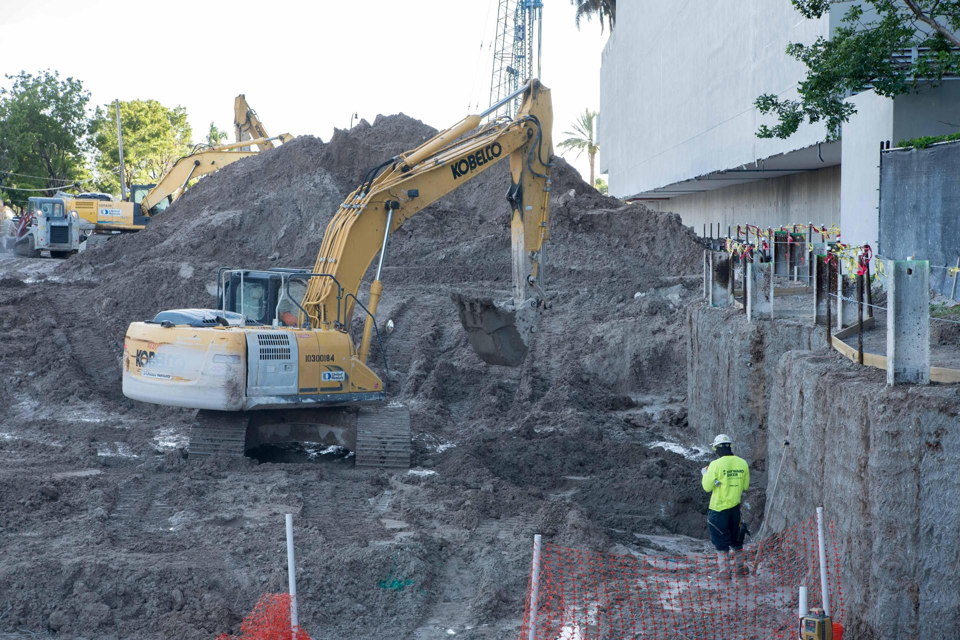

In [59]:
#################################
### Single Image
#################################
import requests
from PIL import Image 

image_path = "/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train/01_001--Optima--09-02-2018-0631.jpg"
image_path = "/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train/01_001--Optima--14-11-2017-5846.jpg"
#image_path = "/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train/01_002AFA69-A930-41C6-8982-20000E50EF97.jpeg"
#image_path = "/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train/01_003--Optima--12-08-2017.jpg"

image = Image.open(image_path).convert('RGB')
smaller_image = image.resize((int(image.width / 2), int(image.height / 2)))

# Display the smaller image
display(smaller_image)

In [60]:
########################################
###Inference with trained model 
########################################
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image



from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image

# Load the model, feature extractor, and tokenizer
model = VisionEncoderDecoderModel.from_pretrained("vision_encoder_decoder/model")
feature_extractor = ViTFeatureExtractor.from_pretrained("vision_encoder_decoder/feature_extractor")
tokenizer = AutoTokenizer.from_pretrained("vision_encoder_decoder/tokenizer")


def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    pixel_values = image_processor(images=image, return_tensors='pt').pixel_values
    return pixel_values

def generate_caption(pixel_values, model, tokenizer, max_length=64, num_beams=4):
    # Generate text
    output_ids = model.generate(pixel_values)
    # Decode the output ids to text
    caption = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
    return caption

pixel_values = preprocess_image(image_path)

caption = generate_caption(pixel_values, model, tokenizer)
print("Generated Caption:", caption)



Generated Caption: an image of EXCAVATOR EXCAVATOR CONTAINER CONTAINER


In [68]:
#################################
### Calculate Accuracy
#################################
from tqdm.notebook import tqdm

image_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/val'
text_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/labels/val'

val_dataset = CustomImageTextDataset(image_dir=image_dir, text_dir=text_dir)

# To use with a DataLoader
from torch.utils.data import DataLoader

matched = 0
total = 200
for i in range(total):
    original_labels = val_dataset[i]["captions"]
    image_path = val_dataset[i]['image_path']
    image = Image.open(image_path)
    
    pixel_values = preprocess_image(image_path)

    caption = generate_caption(pixel_values, model, tokenizer)
    print("Generated Caption:", caption)
    predicted_labels = caption.split()
    
    
    for clazz in predicted_labels:
        if clazz in original_labels: 
            matched += 1
            break
    
    print(f"original: {original_labels} vs predicted {predicted_labels}")
    
accuracy = matched/total

Generated Caption: an image of LUMBER_BUNDLE LUMBER_BUNDLE
original: an image of LUMBER_BUNDLE DOZER LUMBER_BUNDLE SKID_STEER vs predicted ['an', 'image', 'of', 'LUMBER_BUNDLE', 'LUMBER_BUNDLE']
Generated Caption: an image of TIEBACK_RIG EXCAVATOR EXCAVATOR POWER_
original: an image of EXCAVATOR EXCAVATOR LOADER TIEBACK_RIG vs predicted ['an', 'image', 'of', 'TIEBACK_RIG', 'EXCAVATOR', 'EXCAVATOR', 'POWER_']
Generated Caption: an image of EXCAVATOR SKID_STEER
original: an image of EXCAVATOR vs predicted ['an', 'image', 'of', 'EXCAVATOR', 'SKID_STEER']
Generated Caption: an image of FORMWORK_PANEL FORMWORK_PANEL LAD
original: an image of FORMWORK_PANEL LADDER LADDER vs predicted ['an', 'image', 'of', 'FORMWORK_PANEL', 'FORMWORK_PANEL', 'LAD']
Generated Caption: an image of FORMWORK_PANEL FORMWORK_PANEL FORMW
original: an image of DUMPSTER LADDER PLYWOOD LADDER vs predicted ['an', 'image', 'of', 'FORMWORK_PANEL', 'FORMWORK_PANEL', 'FORMW']
Generated Caption: an image of FORMWORK_PANEL FO

Generated Caption: an image of EXCAVATOR TRUCK TRUCK OFFICE_TRAILER
original: an image of EXCAVATOR EXCAVATOR TRUCK OFFICE_TRAILER vs predicted ['an', 'image', 'of', 'EXCAVATOR', 'TRUCK', 'TRUCK', 'OFFICE_TRAILER']
Generated Caption: an image of TOWER_CRANE FORMWORK_PANEL FORMWORK_
original: an image of EXCAVATOR EXCAVATOR CONCRETE_COLUMN LUMBER_BUNDLE vs predicted ['an', 'image', 'of', 'TOWER_CRANE', 'FORMWORK_PANEL', 'FORMWORK_']
Generated Caption: an image of PLYWOOD PLYWOOD
original: an image of LUMBER_BUNDLE vs predicted ['an', 'image', 'of', 'PLYWOOD', 'PLYWOOD']
Generated Caption: an image of FORMWORK_PANEL FORMWORK_PANEL FORMW
original: an image of FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL LADDER vs predicted ['an', 'image', 'of', 'FORMWORK_PANEL', 'FORMWORK_PANEL', 'FORMW']
Generated Caption: an image of LADDER FORMWORK_PANEL FORMWORK_PAN
original: an image of FORMWORK_PANEL LUMBER_BUNDLE LADDER LADDER vs predicted ['an', 'image', 'of', 'LADDER', 'FORMWORK_PANEL', 'FORMWORK

Generated Caption: an image of TOWER_CRANE TOWER_CRANE FORMWORK_PAN
original: an image of TOWER_CRANE TRUCK FORMWORK_PANEL FORMWORK_PANEL vs predicted ['an', 'image', 'of', 'TOWER_CRANE', 'TOWER_CRANE', 'FORMWORK_PAN']
Generated Caption: an image of FORMWORK_PANEL FORMWORK_PANEL CONCRE
original: an image of FORMWORK_PROP_BUNDLE OFFICE_TRAILER TRUCK CONCRETE_COLUMN vs predicted ['an', 'image', 'of', 'FORMWORK_PANEL', 'FORMWORK_PANEL', 'CONCRE']
Generated Caption: an image of EXCAVATOR FORMWORK_PANEL FORMWORK_P
original: an image of LUMBER_BUNDLE FORMWORK_PANEL EXCAVATOR FORMWORK_PANEL vs predicted ['an', 'image', 'of', 'EXCAVATOR', 'FORMWORK_PANEL', 'FORMWORK_P']
Generated Caption: an image of DRILLRIG EXCAVATOR LOADER LOADER
original: an image of DUMPSTER DUMPSTER EXCAVATOR DUMPSTER vs predicted ['an', 'image', 'of', 'DRILLRIG', 'EXCAVATOR', 'LOADER', 'LOADER']
Generated Caption: an image of FORMWORK_PANEL FORMWORK_PANEL FORMW
original: an image of CONTAINER CONTAINER LUMBER_BUNDLE FOR

Generated Caption: an image of DRILLRIG
original: an image of DRILLRIG vs predicted ['an', 'image', 'of', 'DRILLRIG']
Generated Caption: an image of EXCAVATOR BOOMLIFT LADDER CONE
original: an image of EXCAVATOR LADDER LADDER vs predicted ['an', 'image', 'of', 'EXCAVATOR', 'BOOMLIFT', 'LADDER', 'CONE']
Generated Caption: an image of BACKHOE_LOADER EXCAVATOR CONE CONE
original: an image of BACKHOE_LOADER vs predicted ['an', 'image', 'of', 'BACKHOE_LOADER', 'EXCAVATOR', 'CONE', 'CONE']
Generated Caption: an image of TELESCOPIC_HANDLER SKID_STEER CON
original: an image of TELESCOPIC_HANDLER MINI_EXCAVATOR SKID_STEER POWER_GENERATOR vs predicted ['an', 'image', 'of', 'TELESCOPIC_HANDLER', 'SKID_STEER', 'CON']
Generated Caption: an image of PLYWOOD CONTAINER CONTAINER CONTAINER
original: an image of CONTAINER LADDER vs predicted ['an', 'image', 'of', 'PLYWOOD', 'CONTAINER', 'CONTAINER', 'CONTAINER']
Generated Caption: an image of EQUIPMENT PICKUP_TRUCK CONTAINER CONTAINER
original: an image

Generated Caption: an image of SCISSORLIFT
original: an image of TRUCK CONCRETE_COLUMN TOILET_CABIN vs predicted ['an', 'image', 'of', 'SCISSORLIFT']
Generated Caption: an image of FORMWORK_PANEL SCISSORLIFT SCISSORL
original: an image of MINI_EXCAVATOR FORMWORK_PANEL FORMWORK_PANEL FORMWORK_PANEL vs predicted ['an', 'image', 'of', 'FORMWORK_PANEL', 'SCISSORLIFT', 'SCISSORL']
Generated Caption: an image of EXCAVATOR EXCAVATOR TRUCK CONTAINER
original: an image of EXCAVATOR EXCAVATOR TRUCK CONTAINER vs predicted ['an', 'image', 'of', 'EXCAVATOR', 'EXCAVATOR', 'TRUCK', 'CONTAINER']
Generated Caption: an image of GARBAGE_CONTAINER GARBAGE_CONTAINER
original: an image of GARBAGE_CONTAINER TOILET_CABIN vs predicted ['an', 'image', 'of', 'GARBAGE_CONTAINER', 'GARBAGE_CONTAINER']
Generated Caption: an image of TOWER_CRANE FORMWORK_PANEL FORMWORK_
original: an image of MINI_EXCAVATOR TOILET_CABIN CONCRETE_COLUMN CONCRETE_COLUMN vs predicted ['an', 'image', 'of', 'TOWER_CRANE', 'FORMWORK_PANEL'

In [69]:
accuracy

1.0